In [9]:
from pmdarima.arima import auto_arima
from pmdarima.arima.utils import ndiffs
from IPython.core.debugger import set_trace
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import os
plt.style.use(style="seaborn")
%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

In [10]:
df = pd.read_csv("BTC-USD.csv")

<IPython.core.display.Javascript object>

In [11]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Market Cap
0,01/05/2021,57714.66,58448.34,57052.27,57828.05,42836427360,1081174515343
1,02/05/2021,57825.86,57902.59,56141.91,56631.08,38177405335,1058862005057
2,03/05/2021,56620.27,58973.31,56590.87,57200.29,51713139031,1069563935453
3,04/05/2021,57214.18,57214.18,53191.43,53333.54,68564706967,997324142593
4,05/05/2021,53252.16,57911.36,52969.06,57424.01,69241316747,1073873012867


<IPython.core.display.Javascript object>

In [12]:
df = df[["Close"]].copy()

<IPython.core.display.Javascript object>

In [13]:
df.describe()

,Close
count,123.000000
mean,40649.353333
std,7514.317141
min,29807.350000
25%,34632.855000
50%,38402.220000
75%,46586.820000
max,58803.780000


<IPython.core.display.Javascript object>

#### ADF Test

In [14]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.Close.dropna())

print(f"p-value: {result[1]}")
print(f"ADF Statistic: {result[0]}")

ADF Statistic: -2.853855495978991
p-value: 0.05098313417610551


<IPython.core.display.Javascript object>

#### Autocorrelation Function (ACF)

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

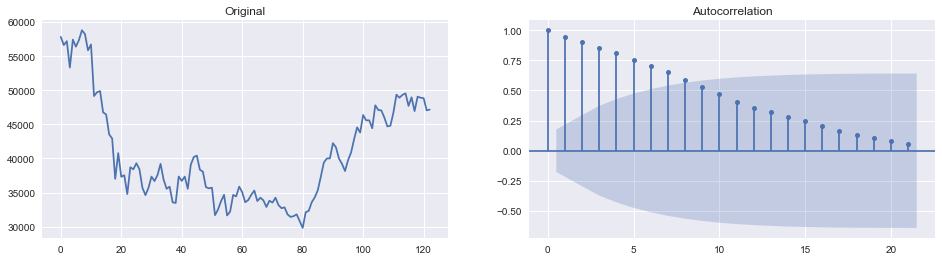

<IPython.core.display.Javascript object>

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.Close)
ax1.set_title("Original")

plot_acf(df.Close, ax=ax2)

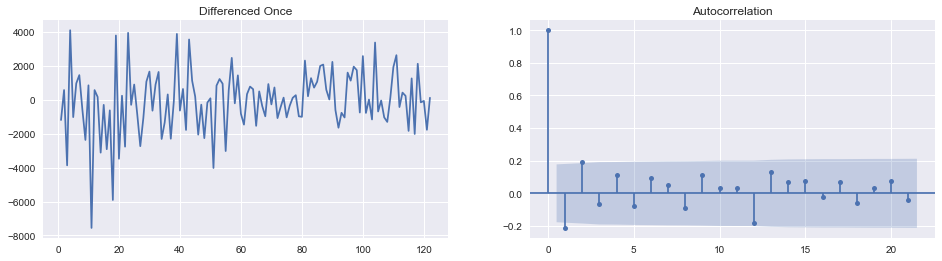

<IPython.core.display.Javascript object>

In [24]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
plot_acf(diff, ax=ax2)

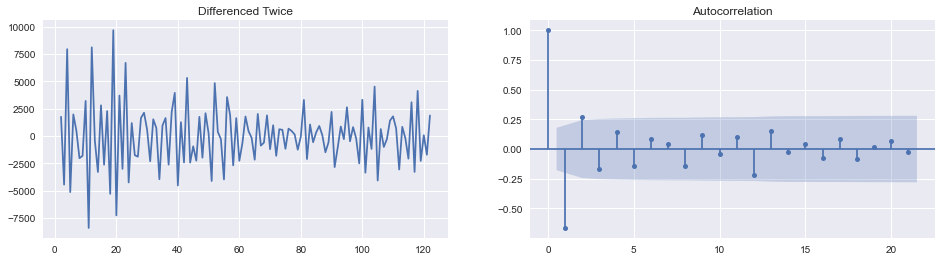

<IPython.core.display.Javascript object>

In [25]:
diff = df.Close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Differenced Twice")
plot_acf(diff, ax=ax2)

In [29]:
ndiffs(df.Close, test="adf")

1

<IPython.core.display.Javascript object>

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

In [ ]:
diff = df.Close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Differenced Once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

#### Fitting the ARIMA Model

In [70]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df.Close, order=(4, 2, 0))
result = model.fit()

<IPython.core.display.Javascript object>

In [71]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  123
Model:                 ARIMA(4, 2, 0)   Log Likelihood               -1120.292
Date:                Wed, 19 Jan 2022   AIC                           2250.583
Time:                        22:34:05   BIC                           2264.562
Sample:                             0   HQIC                          2256.261
                                - 123                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3596      0.025    -14.238      0.000      -0.409      -0.310
ar.L2         -0.2307      0.029     -7.959      0.000      -0.288      -0.174
ar.L3         -0.2366      0.030     -7.901      0.0

<IPython.core.display.Javascript object>

(array([9.80866960e-05, 5.73233937e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.27385319e-06]),
 array([-5994.69924998,   387.57567502,  6769.85060002, 13152.12552502,
        19534.40045001, 25916.67537501, 32298.95030001, 38681.22522501,
        45063.50015   , 51445.775075  , 57828.05      ]),
 <BarContainer object of 10 artists>)

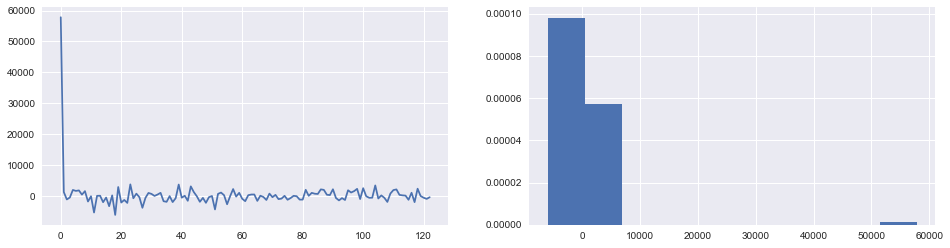

<IPython.core.display.Javascript object>

In [43]:
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


In [ ]:
result.plot_predict(
    start=1, end=60, dynamic=False,
)

### Train-Test Split 

In [47]:
n = int(len(df) * 0.8)
train = df.Close[:n]
test = df.Close[n:]

<IPython.core.display.Javascript object>

In [ ]:
print(len(train))
print(len(test))

In [ ]:
step = 30

model = ARIMA(train, order=(6, 1, 3))
result = model.fit()

fc = result.forecast(step)
ac = result.forecast(step)
conf = result.forecast(step)

In [ ]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

### Auto ARIMA

In [57]:
model = auto_arima(
    df.Close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=6,
    max_q=6,
    m=1,  # Frequency of Series
    d=None,  # Determine 'd'
    seasonal=False,  # No Seasonality in the Data
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2180.601, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2185.475, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2185.166, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2185.429, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2183.752, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2182.136, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2181.953, Time=0.26 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2186.599, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2185.984, Time=0.11 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.76 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=2178.770, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2183.610, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=2183.326, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=2180.311, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

<IPython.core.display.Javascript object>

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = ARIMA(df["Close"], order=(1, 1, 1), seasonal_order=(0, 0, 0, 0))

results = model.fit()
PREDICTIONS = pd.Series(results)

<IPython.core.display.Javascript object>

In [ ]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
results.resid.plot()
plt.ylabel(u"Residuals")
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(results.resid.values.squeeze(), lags=60, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(results.resid)[1])

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib as plt

plt.model
plt.show()